In [1]:
import numpy as np
import scipy
from six import iteritems
from bin.Loader import Loader
from bin.Feature import Feature
from matplotlib import pyplot as plt

from sklearn.svm import SVC

%matplotlib inline

Matplotlib is building the font cache; this may take a moment.


# Set up the dataset

In [2]:
# Load the viral and GTA fasta files 
gta_file = "data/training/gta/3_gta.faa"
viral_file = "data/training/viral/3_viral.faa"
gta_profs = Loader.load(gta_file, "GTA")
viral_profs = Loader.load(viral_file, "virus")

kmer_size = 3
PSE_WEIGHT = 0.05
LAM = 3
PSEAAC = True
PHYSICOCHEM = True

# make kmer features 
features = Feature(gta_profs.profiles+viral_profs.profiles)
features.make_kmer_dict(kmer_size);
features.kmer_feat()

# make pseudo amino acid composition features 
if PSEAAC:
    print(len(features.profiles[1].features), "\n")
    features.pseaac(lam=LAM, weight=PSE_WEIGHT)
    #print(len(features.profiles[1].features), "\n")

# make physico-chemical properties features 
if PHYSICOCHEM:
    features.physicochem()
    #print(len(features.profiles[1].features), "\n")

7157 



In [3]:
# put together the final training dataset
num_to_label_dict = {-1:"GTA", 1:"virus"}
label_to_num_dict = {v:k for k,v in iteritems(num_to_label_dict)}
xs, ys = [], []
profiles = gta_profs.profiles + viral_profs.profiles
for i, profile in enumerate(profiles):
    xs.append(profile.features)
    ys.append(label_to_num_dict[profile.label])
Xtrain = np.array(xs)
Ytrain = np.array(ys).astype(Xtrain.dtype)
print(Xtrain.shape, Ytrain.shape)

(834, 7199) (834,)


In [4]:
### set up the test dataset 
test_file = "example_run/g3_example.faa"
test_profs = Loader.load(test_file)
features.kmer_feat(test_profs)
if PSEAAC:
    features.pseaac(lam=LAM, weight=PSE_WEIGHT, profiles=test_profs)
if PHYSICOCHEM:
    features.physicochem(profiles=test_profs)

In [5]:
xs = []
for profile in test_profs:
    xs.append(profile.features)
Xtest = np.array(xs)
print(Xtest.shape)

(5, 7199)


# Train SVM classifier 


In [6]:
# SV classifier with linear kernel
linear_sv_clf = SVC(C=10000, kernel='linear')
linear_sv_clf.fit(Xtrain, Ytrain);

# SV classifier with RBF kernel 
rbf_sv_clf = SVC(C=10000, kernel='rbf')
rbf_sv_clf.fit(Xtrain, Ytrain);

In [7]:
print([num_to_label_dict[i] for i in linear_sv_clf.predict(Xtest)])

['GTA', 'GTA', 'virus', 'virus', 'virus']


In [8]:
print([num_to_label_dict[i] for i in linear_sv_clf.predict(Xtest)])

['GTA', 'GTA', 'virus', 'virus', 'virus']


Set upRandom Forest classifier

In [9]:
#evaluate random forest algorithm for classification

from numpy import mean
from numpy import std
from numpy import arange

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier

#define the model
model = RandomForestClassifier()

#evaluate the model

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(model, Xtrain, Ytrain, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')

#report performance
print('Accuracy: %.3f Stdev(%.3f)' % (mean(n_scores), std(n_scores)))

Accuracy: 0.999 Stdev(0.003)


In [10]:
model.fit(Xtrain, Ytrain)
model.predict(Xtest)
print([num_to_label_dict[i] for i in model.predict(Xtest)])

['GTA', 'GTA', 'virus', 'virus', 'virus']


In [ ]:
#explore random forest number of features effect on performance

#get a list of models to evaluate
def get_models():
    models=dict()
    #explore number of features from 1 to 7
    for i in range(1,25):
        models[str(i)] = RandomForestClassifier(max_features=i)
    return models

#evaluate a given model using cross-validation
def evaluate_model(model, X, y):
    #define the evaluation procedure
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    #evaluate the model and collect the results
    scores=cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
    return scores


#get the models to evaluate
models = get_models()

#evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    #evaluate the model
    scores = evaluate_model(model, Xtrain, Ytrain)
    #store the results
    results.append(scores)
    names.append(name)
    #summarize the performance along the way
    print ('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
    
#plot model performance for comparison

bp=plt.boxplot(results, labels=names, showmeans=True)


plt.title('Effect of Number of Features on Accuracy')
plt.xlabel('Number of Features')
plt.ylabel('Accuracy')

plt.savefig('features_accuracy.png')

In [ ]:
#explore random forest number of trees effect on performance

#get a list of models to evaluate
def get_models():
    models = dict()
    #define number of trees to consider
    n_trees = [1,2,3,4,5,6,7,8,9, 10] #, 50, 100, 500, 1000]
    for n in n_trees:
        models[str(n)] = RandomForestClassifier(n_estimators=n)
    return models

# evaluate a given model using cross-validation
def evaluate_model(model, X, y):
    # define the evaluation procedure
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    # evaluate the model and collect the results
    scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
    return scores


#get the models

models = get_models()

#evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    #evaluate the model
    scores = evaluate_model(model, Xtrain, Ytrain)
    
    #store the results
    results.append(scores)
    names.append(name)
    
    #summarize the performance along the way
    print('>%s %.3f  (%.3f)' % (name, mean(scores), std(scores)))
    
#plot model performance
plt.boxplot(results, labels=names, showmeans=True)


plt.title('Effect of Number of Trees on Accuracy')
plt.xlabel('Number of Trees')
plt.ylabel('Accuracy')

plt.savefig('numberoftrees_accuracy.png')

In [ ]:
#explore random forest tree depth effect on performance

# get a list of models to evaluate
def get_models():
    models = dict()
    # consider tree depths from 1 to 7 and None=full
    depths = [i for i in range(1,8)] + [None]
    for n in depths:
        models[str(n)] = RandomForestClassifier(max_depth=n)
    return models
 
# evaluate a given model using cross-validation
def evaluate_model(model, X, y):
    # define the evaluation procedure
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    # evaluate the model and collect the results
    scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
    return scores
 

# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    # evaluate the model
    scores = evaluate_model(model, Xtrain, Ytrain)
    # store the results
    results.append(scores)
    names.append(name)
    # summarize the performance along the way
    print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# plot model performance for comparison
plt.boxplot(results, labels=names, showmeans=True)


plt.title('Effect of Tree Depth on Accuracy')
plt.xlabel('Tree Depth')
plt.ylabel('Accuracy')

plt.savefig('treedepth_accuracy.png')

Mean ROC AUC: 1.000


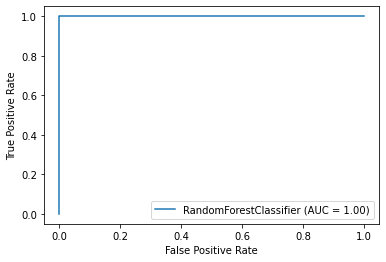

In [15]:
#putting it together...

from sklearn.metrics import plot_roc_curve

#define the model
model = RandomForestClassifier(max_features=18, n_estimators=50, class_weight='balanced')

#evaluate the model

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(model, Xtrain, Ytrain, scoring='roc_auc', cv=cv, n_jobs=-1, error_score='raise')

model.fit(Xtrain, Ytrain)
model.predict(Xtest)

plot_roc_curve(model, Xtrain, Ytrain)
plt.savefig('ROCAUC.png')
#report performance
print('Mean ROC AUC: %.3f' % (mean(n_scores)))

#BLAST

In [ ]:
#imports
import os
from Bio.Blast.Applications import NcbiblastpCommandline
from Bio.Blast import NCBIXML
from Bio import SeqIO
import argparse
import numpy as np
import time
import pandas as pd 
from bin.filter_extract_fasta_ch import extract_fasta
from bin.Loader import Loader
from bin.Weight import Weight
from bin.Feature import Feature
from numpy import mean
from numpy import std
from numpy import arange
from six import iteritems

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier

In [ ]:
def get_dict():
    """function to create a dictionary with info associated with each gta gene, 
    so that when there is a blast hit we can identify which gta gene it is a homolog to"""
    folder = "data/training/gta/"
    folder2 = "data/training/viral/"
    master_dict = {}
    for child in os.listdir(folder):
        if child[-3:] == "faa":
            file = os.path.join(folder,child)
            gene = child.split('_')[0]
            glist = []
            f = open(file)
            content = f.readlines()
            for line in content:
                if line[0] == '>':
                    words = line.split()
                    ID = words[0][1:]
                    glist.append(ID)

            master_dict[gene] = glist

    for child in os.listdir(folder2):
        if child[-3:] == "faa":
            file = os.path.join(folder2,child)
            gene = child.split('_')[0]
            f = open(file)
            content = f.readlines()
            for line in content:
                if line[0] == '>':
                    words = line.split()
                    ID = words[0][1:]
                    master_dict[gene].append(ID)

    return master_dict


In [ ]:
def run_wrapper(querydir, queryname, outdir):


    my_dict = get_dict()

    query_file= querydir + "/" + queryname


    out_dir=outdir
    
    #output file (btab) from the blast against GTA db
    blast_out = out_dir +"/blast"+queryname + ".out"
    #special blast outformat parameters
    outformat = "6 qseqid sstart send sframe sseqid pident qlen slen length mismatch gapopen qstart qend evalue bitscore"
    #run blast search using database of viral and GTA training set
    blastp_cline = NcbiblastpCommandline(query=query_file, db="data/GTA_db/GTA_viral", evalue=0.001, outfmt=outformat, out=blast_out, num_threads=2,dbsize=10000000)
    blastp_cline
    stdout,stderr = blastp_cline()
    result = open(blast_out)
    lines = result.readlines()
    result.close()
    handle_in = open(query_file)
    #keep track of which sequences did not have a GTA homolog
    no_hit_list = []
    for record in SeqIO.parse(handle_in, "fasta"):
        no_hit_list.append(record.id)
    handle_in.close()
    
    
    

    #continue if blast search had results
    if len(lines) > 0:
        #file to store the results of running GTA_Hunter
        results_file = out_dir + "/results" +queryname+".out"

        #run script to extract fasta files from blast search
        genes_found = extract_fasta(blast_out,query_file,out_dir,my_dict,queryname)
        


        if len(genes_found) > 0:
            results_handle = open(results_file, 'w')
            
            
            # for each GTA gene that had homologs, run GTA Hunter
            for gene in genes_found:
                
                
                out_faa = out_dir + "/gta_homolog_" +gene+queryname+".faa"
                
                results_handle.write(str(out_faa)+"\n")
                
                print(out_faa)
                
            
    
                #get training files corresponding to the gene identified
                gta_file = "data/training/gta/" + gene + "_gta.faa"
                viral_file = "data/training/viral/" + gene + "_viral.faa"
                gta_weight = "data/training/gta/" + gene + "_gta.dist"
                virus_weight = "data/training/viral/" + gene + "_viral.dist"
                
                
                gta_profs = Loader.load(gta_file, "GTA")
                viral_profs = Loader.load(viral_file, "virus")
                kmer_size = 3
                PSE_WEIGHT = 0.05
                LAM = 3
                PSEAAC = True
                PHYSICOCHEM = True

                # make kmer features 
                features = Feature(gta_profs.profiles+viral_profs.profiles)
                features.make_kmer_dict(kmer_size);
                features.kmer_feat()

                # make pseudo amino acid composition features 
                if PSEAAC:
                    print(len(features.profiles[1].features), "\n")
                    features.pseaac(lam=LAM, weight=PSE_WEIGHT)
    

                # make physico-chemical properties features 
                if PHYSICOCHEM:
                    features.physicochem()
                    
                num_to_label_dict = {-1:"GTA", 1:"virus"}
                label_to_num_dict = {v:k for k,v in iteritems(num_to_label_dict)}
                xs, ys = [], []
                profiles = gta_profs.profiles + viral_profs.profiles
                for i, profile in enumerate(profiles):
                    xs.append(profile.features)
                    ys.append(label_to_num_dict[profile.label])
                Xtrain = np.array(xs)
                Ytrain = np.array(ys).astype(Xtrain.dtype)
                #print(Xtrain.shape, Ytrain.shape)
                
                

                test_profs = Loader.load(out_faa)
                features.kmer_feat(test_profs)
                if PSEAAC:
                    features.pseaac(lam=LAM, weight=PSE_WEIGHT, profiles=test_profs)
                if PHYSICOCHEM:
                    features.physicochem(profiles=test_profs)
                    
                xs = []
                for profile in test_profs:
                    xs.append(profile.features)
                Xtest = np.array(xs)
                #print(Xtest.shape)
                
                linear_sv_clf = SVC(C=10000, kernel='linear')
                linear_sv_clf.fit(Xtrain, Ytrain);

                # SV classifier with RBF kernel 
                rbf_sv_clf = SVC(C=10000, kernel='rbf')
                rbf_sv_clf.fit(Xtrain, Ytrain);
                #print("THE SVM CLASSIFIER PREDICTS:", [num_to_label_dict[i] for i in linear_sv_clf.predict(Xtest)])
                results_handle.write("THE SVM CLASSIFIER PREDICTS:"+str([num_to_label_dict[i] for i in linear_sv_clf.predict(Xtest)])+"\n")
                
                #Random Forest Classifier
                RFClassifier = RandomForestClassifier(max_features=18, n_estimators=50, class_weight='balanced')
                RFClassifier.fit(Xtrain, Ytrain)
                RFClassifier.predict(Xtest)
                #print("THE RANDOM FOREST CLASSIFIER PREDICTS:",[num_to_label_dict[i] for i in RFClassifier.predict(Xtest)])
                results_handle.write("THE RANDOM FOREST CLASSIFIER PREDICTS:"+str([num_to_label_dict[i] for i in RFClassifier.predict(Xtest)])+"\n")

            results_handle.close()
            #close original query file and GTA_Hunter results file
            results_handle = open(results_file)
            lines = results_handle.readlines()

            #update the list of sequences that did not have a GTA homolog
            for line in lines:
                words = line.split()
                if words[0] != "Gene":
                    if words[0][1:] in no_hit_list:
                        no_hit_list.remove(words[0][1:])
            results_handle.close()            
                
                
    else:
        #if the blast.out file is empty
        print("Sorry, no GTA homologs were found")

    #write out a list of gene IDs of genes that were not homologs to any GTA gene 
    no_hit_file = out_dir+ "/no_homologs" +queryname+".txt"
    no_hit_handle = open(no_hit_file,'w')
    for nohit in no_hit_list:
        no_hit_handle.write(nohit + '\n')
    no_hit_handle.close()



In [ ]:
run_wrapper("Citro_Eryth","NZ_WTZA01000001.faa", "Citro_Eryth/Results")

In [ ]:
Citro_Eryth="/Users/alexandrawalling/Dropbox (AMNH)/ML_Project/GTA-Hunter-v1-master-2/Citro_Eryth"

for file in os.listdir(Citro_Eryth):
    print(file)
    run_wrapper(Citro_Eryth, file, "Citro_Eryth/Results")

In [ ]:
Alphaproteobacteria = "/Users/alexandrawalling/Dropbox (AMNH)/ML_Project/GTA-Hunter-v1-master-2/ncbi-genomes-2021-05-18"


for file in os.listdir(Alphaproteobacteria):
    run_wrapper(Alphaproteobacteria, file, "/Users/alexandrawalling/Dropbox (AMNH)/ML_Project/GTA-Hunter-v1-master-2/ncbi-genomes-2021-05-18/Results")